# EDA Prep FE 2nd

## 목표

- 아파트 아이디 변환 : 순서가 있는 int형 카테고리
- 평당가 계산하기
    1. row별로 평당가 계산 - 기준은? 공급면적, 전용면적을 구한 뒤, 수식으로 공용면적도 구하기
    2. 동별로 평당가 mean, median, std 구해서 비교ㅁ
- school, subway : eda

## 결과

- 아파트 아이디 변환 : test에만 있는 12개 단지는 mid값으로 넣음
- null data 추정 : 그리드 서치로 lgb 파라미터 조절한 다음 바로 추정

### subway

- 역세권
    - 1차 : 200m
    - 2차 : 500m
    - 3차 : 800m : 1km가 아닌 이유 : 단순히 직선거리로 재기 때문에 실소요거리는 더 길 것임
- 더블 역세권
    - 환승역
    - 나머지는 기준이 애매함. 일단 3차도 도보 10분 이내이므로 3차까지 포함해서 계산
- 지하철역의 가치 : logPrice
    - 역세권에 속하는 단지 아이디의 타겟값을 활용해서 지하철역의 가치를 계산할 수 있음
    - 예) 강남역, 판교역 등은 다른 역주변보다 비쌈
- 지하철역 구/동 : disTown - 법정동코드 000000 형태
- 환승역 갯수 : noLine
    
### school

- private
- onlySex

## 부족한 부분

- 아파트 단지와 지하철/학교와의 거리 구하기 연산 시간 너무 길다...
- 평당가 계산하기 : logPrice로 계산해야 할까, raw price로 계산한 뒤에 log를 씌우는 게 맞을까, 일단 후자 택

## 새로운 아이디어

- 평당가를 구하자
- 법정동 가치 구하기 : 평당가를 활용해서 가치 산출
    - 지하철 가치 산출 가능
    - 학교 가치 산출 가능

In [1]:
import pandas as pd
import numpy as np
import os, sys, warnings, re, time, gc,math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import RidgeCV as ridge
import lightgbm as lgb

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.dirname('../')))
from modules import eda
gc.collect()

0

In [2]:
%%time
path = './datasets/origin/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
# school = pd.read_csv(path+'Schools.csv')
# subway = pd.read_csv(path+'Subways.csv')
gc.collect()

Wall time: 9.02 s


In [28]:
train.to_csv('./datasets/trainFE3rd.csv', index=False)
test.to_csv('./datasets/testFE3rd.csv', index=False)
# subway.to_csv('./datasets/subwayFE2nd.csv', index=False)
# school.to_csv('./datasets/schoolFE2nd.csv', index=False)

# groupedTowns.to_csv('./datasets/groupedTown.csv', index=False)
# subDist.to_csv('./datasets/subDist.csv', index=False)

In [3]:
def colInfo(col, train=train):
    dtype = train[col].dtypes
    print(dtype)
    if dtype == 'float64' : 
        print(train[col].describe())
    else:
        uniq = train[col].unique()
        if dtype == 'O' or len(uniq)<100: 
            print(train[col].value_counts(dropna=False))
        else : 
            print(train[col].describe())
    isna(col, train)
            
def isna(col, train=train):
    print('train na : ', sum(train[col].isna()))

In [5]:
# 연산용 코드모음
apart = 'apartment_id'
target = 'logPrice'
lat = 'latitude'
lot = 'longitude'
allUniq = list(set(train[apart].unique().tolist()+test[apart].unique().tolist()))
mid = (len(allUniq)-12)//2
onlyTest = list(set(test[apart].unique())-set(train[apart].unique()))

# 아파트명 순서가 있는 int형 index로 변형
meanApart = train[[target, apart]].groupby([apart]).agg('mean')
meanApart=meanApart.sort_values(by=[target])
apartCnvt = {}
apartId = meanApart.index.tolist()
for i in range(mid):
    apartCnvt[apartId[i]] = i+1
for i in range(12):
    apartCnvt[onlyTest[i]] = mid+i+1
for i in range(mid, mid*2):
    apartCnvt[apartId[i]] = i+13
train['apart'] = train[apart].apply(lambda row : apartCnvt[row])
test['apart'] = test[apart].apply(lambda row : apartCnvt[row])

# # 지하철 역과의 거리 구하기
# station = subway['station_id'].tolist()
# apartId = test[apart].unique().tolist()
# subDict = {}
# length = len(apartId)
# for stat in station:
#     subDict[stat] = [None for i in range(length)]
# subDist = pd.DataFrame(subDict, index=apartId)
# apartLoc = test[[apart, lat, lot]].groupby([apart]).agg('mean')
# statLoc = subway[['station_id', lat, lot]].groupby(['station_id']).agg('mean')
# for s in station:
#     for a in apartId:
#         width = (statLoc.loc[s, lat] - apartLoc.loc[a, lat])*88740
#         height = (statLoc.loc[s, lot] - apartLoc.loc[a, lot])*110000
#         subDist.loc[a, s]=math.sqrt(width**2+height**2)

# 지하철역 구/동 위치 구하기
disTownPrice = train[['disTown', target]].groupby(['disTown']).agg(['mean','median'])
def disTownCnvrt(x):
    try : return int(str(x)[2:8])
    except ValueError : return np.nan
subway['disTown'] = subway['address_by_law'].apply(lambda row : disTownCnvrt(row))

# 지하철역 가치 구하기
def priceCnvrt(x):
    try : return disTownPrice[target]['median'][int(x)]
    except KeyError : return np.nan
    except ValueError : return np.nan
subway[target] = subway['disTown'].apply(lambda row : priceCnvrt(row))

# 지하철역 노선 갯수
subway['noLine'] = subway['subway_line'].apply(lambda row : len(row.split(',')))

## Apartment id

In [5]:
apart = 'apartment_id'
# target = 'logPrice'
# train[target] = np.log(train['transaction_real_price'])
# train.to_csv('./datasets/trainFe1st.csv', index=False)

In [18]:
allUniq = list(set(train[apart].unique().tolist()+test[apart].unique().tolist()))
print(len(allUniq))
print('only test', set(test[apart].unique())-set(train[apart].unique()))
print('only train', set(train[apart].unique())-set(test[apart].unique()))
mid = (len(allUniq)-12)//2
print(mid)

3918
only test {36224, 38465, 22247, 36841, 37353, 37354, 37297, 37431, 26553, 37180, 33373, 37086}
only train set()
1953


In [8]:
onlyTest = list(set(test[apart].unique())-set(train[apart].unique()))
midApart = train[[target, apart]].groupby([apart]).agg('median')
meanApart = train[[target, apart]].groupby([apart]).agg('mean')
print(midApart.head(10))
print(meanApart.head(10))

3906
               logPrice
apartment_id           
3             20.401682
4             20.069339
5             20.125429
24            18.792244
26            21.045349
30            20.431576
31            21.274273
32            21.091375
33            20.426868
34            20.474804
               logPrice
apartment_id           
3             20.382581
4             20.045308
5             20.177104
24            18.682810
26            21.026528
30            20.425086
31            21.239399
32            21.061784
33            20.453365
34            20.489188


Skewed:  -0.07944718426559089
Kurtosis:  0.2178878686573391


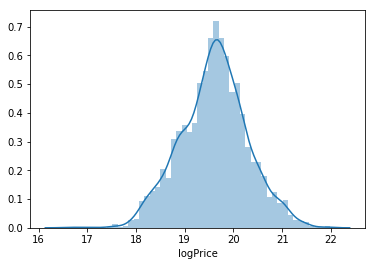

In [12]:
sns.distplot(midApart[target])
print("Skewed: ", midApart[target].skew())
print("Kurtosis: ", midApart[target].kurt())

Skewed:  -0.08724618280060677
Kurtosis:  0.08632898784966159


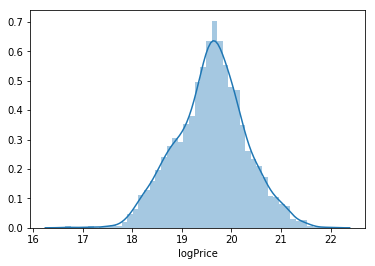

In [11]:
sns.distplot(meanApart[target])
print("Skewed: ", meanApart[target].skew())
print("Kurtosis: ", meanApart[target].kurt())

In [19]:
meanApart=meanApart.sort_values(by=[target])
apartCnvt = {}
apartId = meanApart.index.tolist()
for i in range(mid):
    apartCnvt[apartId[i]] = i+1
for i in range(12):
    apartCnvt[onlyTest[i]] = mid+i+1
for i in range(mid, mid*2):
    apartCnvt[apartId[i]] = i+13
print(len(set(apartCnvt.keys())))

3918


In [21]:
train['apart'] = train[apart].apply(lambda row : apartCnvt[row])
test['apart'] = test[apart].apply(lambda row : apartCnvt[row])

## 평당가 계산

- 1$m^2$당 계산

In [18]:
train.columns

Index(['key', 'apartment_id', 'city', 'transaction_year_month',
       'transaction_date', 'year_of_completion', 'exclusive_use_area', 'floor',
       'latitude', 'longitude', 'address_by_law',
       'total_parking_capacity_in_site', 'total_household_count_in_sites',
       'apartment_building_count_in_sites', 'tallest_building_in_sites',
       'lowest_building_in_sites', 'heat_type', 'heat_fuel', 'room_id',
       'supply_area', 'total_household_count_of_area_type', 'room_count',
       'bathroom_count', 'front_door_structure', 'transaction_real_price',
       'transYear', 'transMonth', 'transDate', 'transYMD', 'transOrdered',
       'commonArea', 'areaRate', 'district', 'town', 'disTown', 'cityDisTown',
       'logPrice', 'apart', 'exAreaPrice', 'supAreaPrice', 'comAreaPrice',
       'logExAreaPrice', 'logSupAreaPrice'],
      dtype='object')

In [11]:
%%time
target = 'transaction_real_price'
train['exAreaPrice'] = train.apply(lambda row : row[target]/row['exclusive_use_area'],axis=1)
train['supAreaPrice'] = train.apply(lambda row : row[target]/row['supply_area'],axis=1)

test['exAreaPrice'] = test.apply(lambda row : row[target]/row['exclusive_use_area'],axis=1)
test['supAreaPrice'] = test.apply(lambda row : row[target]/row['supply_area'],axis=1)

Wall time: 1min 4s


In [13]:
# %%time
# 이건 뭔가 실패한 듯
# train['comAreaPrice']=train.apply(lambda row : row['supAreaPrice']-(row['exAreaPrice']*row['areaRate']),axis=1)
# test['comAreaPrice']=test.apply(lambda row : row['supAreaPrice']-(row['exAreaPrice']*row['areaRate']),axis=1)

Wall time: 44.9 s


In [14]:
train[['comAreaPrice','exAreaPrice','supAreaPrice']].head(10)

,comAreaPrice,exAreaPrice,supAreaPrice
0,0.000000e+00,4.532996e+06,3.275941e+06
1,-4.656613e-10,4.507550e+06,3.257860e+06
2,0.000000e+00,3.071298e+06,2.321725e+06
3,0.000000e+00,2.551809e+06,1.890034e+06
4,4.656613e-10,2.626149e+06,2.191952e+06
5,0.000000e+00,4.886952e+06,3.776847e+06
6,0.000000e+00,4.450000e+06,3.166133e+06
7,-4.656613e-10,4.896177e+06,3.978907e+06
8,0.000000e+00,3.652215e+06,2.879703e+06
9,-4.656613e-10,5.321989e+06,3.713620e+06


In [16]:
train['logExAreaPrice'] = np.log(train['exAreaPrice'])
test['logExAreaPrice'] = np.log(test['exAreaPrice'])
train['logSupAreaPrice'] = np.log(train['supAreaPrice'])
test['logSupAreaPrice'] = np.log(test['supAreaPrice'])

In [17]:
train[['logExAreaPrice','logSupAreaPrice']].head(10)

,logExAreaPrice,logSupAreaPrice
0,15.326894,15.002116
1,15.321264,14.996581
2,14.937611,14.657821
3,14.752313,14.452106
4,14.781029,14.600303
5,15.402079,15.144400
6,15.308415,14.968022
7,15.403965,15.196518
8,15.110844,14.873198
9,15.487358,15.127518


### 동별 평단가 구하기

In [39]:
towns = set(test['cityDisTown'].unique().tolist())
print(len(towns))

368


In [8]:
# Area
train['commonArea'] = train.apply(lambda row : row['supply_area']-row['exclusive_use_area'], axis=1)
test['commonArea'] = test.apply(lambda row : row['supply_area']-row['exclusive_use_area'], axis=1)
train['areaRate'] = train.apply(lambda row : row['exclusive_use_area']/row['supply_area'], axis=1)
test['areaRate'] = test.apply(lambda row : row['exclusive_use_area']/row['supply_area'], axis=1)

# location by law
train['district'] = train['address_by_law'].apply(lambda row : int(str(row)[2:5]))
test['district'] = test['address_by_law'].apply(lambda row : int(str(row)[2:5]))
train['town'] = train['address_by_law'].apply(lambda row : int(str(row)[5:8]))
test['town'] = test['address_by_law'].apply(lambda row : int(str(row)[5:8]))
train['disTown'] = train.apply(lambda row : int(str(row['district'])+str(row['town'])), axis=1)
test['disTown'] = test.apply(lambda row : int(str(row['district'])+str(row['town'])), axis=1)
train['cityDisTown'] = train.apply(lambda row : int(str(row['city'])+str(row['disTown'])), axis=1)
test['cityDisTown'] = test.apply(lambda row : int(str(row['city'])+str(row['disTown'])), axis=1)

In [6]:
train['logPrice']=np.log(train['transaction_real_price'])

## ~ price
target = 'transaction_real_price'
train['exAreaPrice'] = train.apply(lambda row : row[target]/row['exclusive_use_area'],axis=1)
train['supAreaPrice'] = train.apply(lambda row : row[target]/row['supply_area'],axis=1)
# test['exAreaPrice'] = test.apply(lambda row : row[target]/row['exclusive_use_area'],axis=1)
# test['supAreaPrice'] = test.apply(lambda row : row[target]/row['supply_area'],axis=1)
train['logExAreaPrice'] = np.log(train['exAreaPrice'])
# test['logExAreaPrice'] = np.log(test['exAreaPrice'])
train['logSupAreaPrice'] = np.log(train['supAreaPrice'])
# test['logSupAreaPrice'] = np.log(test['supAreaPrice'])

In [21]:
# unitPriceCnvrt = {}
# groupedTowns = train[['cityDisTown','logSupAreaPrice']].groupby(['cityDisTown']).agg(['median'])
# for idx, price in zip(groupedTowns['logSupAreaPrice']['median'].index, groupedTowns['logSupAreaPrice']['median'].values):
#     unitPriceCnvrt[idx] = price
# train['unitPrcie'] = train.apply(lambda row : row['transaction_real_price']/row['supply_area'], axis=1)
train['townUnitPrice'] = train['cityDisTown'].apply(lambda row : unitPriceCnvrt[row])
test['townUnitPrice'] = test['cityDisTown'].apply(lambda row : unitPriceCnvrt[row])

{110101: 14.154268590869162,
 110102: 13.889212347096956,
 110115: 13.898403766405217,
 110120: 14.25662217728737,
 140102: 14.888455099883807,
 140103: 14.291950137687538,
 140104: 15.14081934557303,
 140105: 14.48083780032231,
 140106: 14.522177288611733,
 140107: 14.96464075406443,
 140111: 14.60427749005045,
 140112: 14.749326850602554,
 140116: 13.681305445830553,
 140123: 14.280913024108736,
 140124: 14.242919600725148,
 170101: 14.448475591119742,
 170102: 14.177178285891745,
 170103: 14.306165229349318,
 170104: 14.67303715970034,
 200103: 14.413171904407129,
 200109: 14.830713840808357,
 200111: 14.422480042283167,
 200113: 13.611722941275442,
 200115: 14.419067734737553,
 200116: 14.55465364513244,
 200118: 14.075762768674078,
 200119: 13.838965300668171,
 200120: 14.256748026702036,
 200121: 14.14401462493631,
 230101: 14.624346867655223,
 230102: 14.522300214850024,
 230103: 14.760380953180471,
 230104: 14.56178479358245,
 230105: 14.7888677961373,
 230106: 14.6005025639719

In [9]:
groupedTowns = train[['cityDisTown','logExAreaPrice','logSupAreaPrice']].groupby(['cityDisTown']).agg(['mean','median','std'])
print(groupedTowns.tail(10))

            logExAreaPrice                      logSupAreaPrice             \
                      mean     median       std            mean     median   
cityDisTown                                                                  
1710114          15.508575  15.477923  0.169914       15.235418  15.208193   
1740101          15.640758  15.638292  0.233054       15.389918  15.392507   
1740102          15.822453  15.836988  0.290382       15.534721  15.555307   
1740103          15.530104  15.508829  0.254912       15.272063  15.262830   
1740105          15.391597  15.389520  0.215121       15.214799  15.213320   
1740106          15.789885  15.779029  0.374799       15.608816  15.552840   
1740107          15.717210  15.734266  0.227480       15.421014  15.447194   
1740108          15.561727  15.563201  0.202263       15.265501  15.260787   
1740109          15.427219  15.424429  0.236170       15.138632  15.149270   
1740110          15.426308  15.422981  0.215051       15.153342 

In [15]:
print(groupedTowns.mean())
print(groupedTowns.max())
print(groupedTowns.min())

logExAreaPrice   mean      15.337483
                 median    15.348899
                 std        0.263760
logSupAreaPrice  mean      15.087603
                 median    15.101387
                 std        0.260356
dtype: float64
logExAreaPrice   mean      16.591483
                 median    16.592872
                 std        0.636723
logSupAreaPrice  mean      16.307454
                 median    16.292393
                 std        0.527532
dtype: float64
logExAreaPrice   mean      13.718577
                 median    13.805442
                 std        0.066299
logSupAreaPrice  mean      13.574745
                 median    13.611723
                 std        0.066305
dtype: float64


## 단지별 평당가 구하기

In [4]:
train.columns

Index(['key', 'apartment_id', 'city', 'transaction_year_month',
       'transaction_date', 'year_of_completion', 'exclusive_use_area', 'floor',
       'latitude', 'longitude', 'address_by_law',
       'total_parking_capacity_in_site', 'total_household_count_in_sites',
       'apartment_building_count_in_sites', 'tallest_building_in_sites',
       'lowest_building_in_sites', 'heat_type', 'heat_fuel', 'room_id',
       'supply_area', 'total_household_count_of_area_type', 'room_count',
       'bathroom_count', 'front_door_structure', 'transaction_real_price',
       'unitPrice'],
      dtype='object')

In [10]:
# 단지 평당가를 구하자 :
# train['unitPrice'] = train.apply(lambda row : row['transaction_real_price']/row['supply_area'], axis=1)
# groupedUnitPrice = train[['unitPrice', 'apartment_id']].groupby(['apartment_id']).agg('median')
apartUnitPriceCnvrt = {}
for apartId, price in zip(groupedUnitPrice['unitPrice'].index, groupedUnitPrice['unitPrice'].values):
    apartUnitPriceCnvrt[apartId] = price
def apartUnitPrice(x):
    try : return apartUnitPriceCnvrt[x]
    except KeyError : return np.nan
train['apartUnitPrice'] = train['apartment_id'].apply(lambda row : apartUnitPrice(row))
test['apartUnitPrice'] = test['apartment_id'].apply(lambda row : apartUnitPrice(row))

In [12]:
test['apartUnitPrice'].isna().sum()

12

## Null Prep

In [3]:
def coList(col=None):
    cols = [
     'lowest_building_in_sites',
     'transMonth',
     'commonArea',
     'sub500',
     'sub800',
     'heat_fuel',
     'latitude',
     'bathroom_count',
     'transOrdered',
     'sub200',
     'transYear',
     'heat_type',
     'supply_area',
     'disTown',
     'year_of_completion',
     'total_parking_capacity_in_site',
     'areaRate',
     'total_household_count_in_sites',
     'longitude',
     'sub200Price',
     'front_door_structure',
     'city',
     'transaction_year_month',
     'tallest_building_in_sites',
     'total_household_count_of_area_type',
     'apart',
     'floor',
     'sub800Price',
     'exclusive_use_area',
     'room_count',
     'sub500Price',
     'cityDisTown',
     'transYMD',
     'apartment_building_count_in_sites',
    ]
    cats = ['heat_fuel', 'heat_type','front_door_structure', 'city', 'apart', 'cityDisTown',]
    if col is not None : 
        cols.remove(col)
        if col in cats: cats.remove(col)
    return cols, cats
    
# path = './datasets/'
# train = pd.read_csv(path+'trainFe2nd.csv')
# test = pd.read_csv(path+'testFe2nd.csv')
cols, cats = coList()
data = train[cols].append(test[cols])

### Obj Type Convert

In [23]:
col = 'heat_fuel'
def heatFuel(x):
    if x =='gas' : return 0
    elif x=='cogeneration': return 1
    else : return 2
data[col] = data[col].apply(lambda row : heatFuel(row))
train[col] = train[col].apply(lambda row : heatFuel(row))
test[col] = test[col].apply(lambda row : heatFuel(row))

col = 'heat_type'
def heaType(x):
    if x=='individual': return 0
    elif x=='district':return 1
    elif x=='central':return 2
    else : return 3
data[col] = data[col].apply(lambda row : heaType(row))
train[col] = train[col].apply(lambda row : heaType(row))
test[col] = test[col].apply(lambda row : heaType(row))

col = 'front_door_structure'
def FDS(x):
    if x=='stairway': return 0
    elif x=='corridor': return 2
    elif x=='mixed': return 1
    else : return 3
data[col] = data[col].apply(lambda row : FDS(row))
train[col] = train[col].apply(lambda row : FDS(row))
test[col] = test[col].apply(lambda row : FDS(row))

## Null Main

In [5]:
def trainLgb(col, model=None):
    print('first run')
    cols, cats = coList(col)
    trainSet = data[~pd.isna(data[col])]
    label = trainSet[col].values
    lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
    bst = lgb.train(params, lgbSet)
    
    print('second run')
    for i,v in enumerate(bst.feature_importance('gain')):
        if v<10: cols[i]=0
    cols = [i for i in cols if i!=0]
    cats = list(set(cols)&set(cats))

    lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
    bst = lgb.train(params, lgbSet)
    if model is not None : bst.save_model(model+'.txt')
    
    print('predict train')
    predSet = train[pd.isna(train[col])]
    idx = predSet.index.tolist()
    predArray = predSet[cols]
    predicted = bst.predict(predArray.values)
    for i, v in enumerate(idx):
        train[col][v] = predicted[i]
        
    print('predict test')
    predSet = test[pd.isna(test[col])]
    idx = predSet.index.tolist()
    predArray = predSet[cols]
    predicted = bst.predict(predArray.values)
    for i, v in enumerate(idx):
        test[col][v] = predicted[i]
        
nullCols = ['room_count','bathroom_count','total_parking_capacity_in_site',
            'tallest_building_in_sites',]
params = {
    'objective':'regression',
    'metric':'l2',
    'num_threads':3,
#     'device_type':'gpu',
}

def applyRound(x):
    if x-int(x)>0.5: return int(x)+1
    else : return int(x)

In [28]:
col = 'room_count'

bst = trainLgb(col)

predSet = train[pd.isna(train[col])]
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)
for i, v in enumerate(idx):
    train[col][v] = predicted[i]
print(train[col].unique())
        
predSet = test[pd.isna(test[col])]
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)
for i, v in enumerate(idx):
    test[col][v] = predicted[i]
print(test[col].unique())


train[col] = train[col].apply(lambda row : applyRound(row))
test[col] = test[col].apply(lambda row : applyRound(row))

print(train[col].unique())
print(test[col].unique())

[1 2 4 3 5 0 6 8 7]
[3 0 2 4 1 5 6]


In [31]:
%%time
col = 'bathroom_count'
print(train[col].value_counts(dropna=False))
print(test[col].value_counts(dropna=False))
# trainLgb(col)
print(train[col].value_counts(dropna=False))
print(test[col].value_counts(dropna=False))

train[col] = train[col].apply(lambda row : applyRound(row))
test[col] = test[col].apply(lambda row : applyRound(row))
print(train[col].unique())
print(test[col].unique())

2.000000    926898
1.000000    662676
3.000000      7627
0.000000      3231
4.000000       334
1.120463       181
1.064729        77
1.294330        41
1.293866        41
1.123588        36
2.005695        27
1.029664        25
1.016877        23
1.298349        22
1.121136        21
1.999038        20
1.124260        17
1.298557        15
1.007611        15
1.997265        13
1.007299        11
1.999960        11
1.007678         9
1.038784         9
1.008625         9
1.308537         8
1.285725         6
1.276335         6
1.008376         6
1.326106         6
1.080177         4
1.008080         4
2.016980         4
1.138259         4
2.001426         3
1.481281         3
1.533262         3
1.126216         3
1.009406         2
1.989481         2
1.121202         2
5.000000         1
1.079230         1
1.724961         1
Name: bathroom_count, dtype: int64
2.000000    2465
1.000000    1409
3.000000      26
0.000000      11
4.000000       2
2.005695       1
1.481281       1
1.007299  

In [33]:
%%time
col = 'total_parking_capacity_in_site'
# print(train[col].unique())
# print(test[col].unique())
# trainLgb(col)
print(train[col].unique())
print(test[col].unique())

train[col] = train[col].apply(lambda row : applyRound(row))
test[col] = test[col].apply(lambda row : applyRound(row))
print(train[col].unique())
print(test[col].unique())

[ 163.  902. 1365. ...  903.  484.  807.]
[ 375.           45.5846042    14.25271935 ...  570.          802.
 1128.        ]
[ 163  902 1365 ... 1211  903  484]
[ 375   46   14 ... 1673  570 1128]
Wall time: 1.21 s


In [6]:
%%time
col = 'tallest_building_in_sites'
print(train[col].unique())
print(test[col].unique())
trainLgb(col)
print(train[col].unique())
print(test[col].unique())

train[col] = train[col].apply(lambda row : applyRound(row))
test[col] = test[col].apply(lambda row : applyRound(row))
print(train[col].unique())
print(test[col].unique())

[ 8. 14. 15. 23. 20. 18. 30. 22. 25. 21. 19. 13. 12.  6.  5. 24. 28. 10.
 27. 17.  7. 16. 11. 26.  9. 31. 29. 35. 39. 66. 40. 49. 33. 36. 37. 46.
 38. 55. 43. 34. 51. 69. 32. 50. 41. 47. 58. 45. 42. 52. 48. 60. 44. 80.
 72. 53. 56. nan]
[15.  5. 16. 10. 14. 33.  6. 21. 25. 13. 19.  7. 18. 20. 11.  9. 27. 12.
 23. 37. 29. 35. 28. 24. 17. 30.  8. 47. 49. 32. 22. 26. 44. 34. 41. 39.
 42. 48. 38. 36. 31. nan 45. 46. 40. 56. 43. 58. 66. 55. 69. 52. 53. 51.
 60. 72. 80. 50.]
first run
second run
predict train
predict test
[ 8.         14.         15.         23.         20.         18.
 30.         22.         25.         21.         19.         13.
 12.          6.          5.         24.         28.         10.
 27.         17.          7.         16.         11.         26.
  9.         31.         29.         35.         39.         66.
 40.         49.         33.         36.         37.         46.
 38.         55.         43.         34.         51.         69.
 32.         50.       

In [16]:
col = 'front_door_structure'
params = {
    'objective':'multiclass',
#     'metric':'l2',
    'num_class':3,
    'num_threads':3,
#     'device_type':'gpu',
}
cols, cats = coList(col)
trainSet = data[data[col]!=3]
label = trainSet[col].values
lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
bst = lgb.train(params, lgbSet)
    
for i,v in enumerate(bst.feature_importance('gain')):
    if v<10: cols[i]=0
cols = [i for i in cols if i!=0]
cats = list(set(cols)&set(cats))

lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
bst = lgb.train(params, lgbSet)

predSet = train[train[col]==3]
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)
for i, v in enumerate(idx):
    train[col][v] = predicted[i].tolist().index(max(predicted[i]))

predSet = test[test[col]==3]
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)
for i, v in enumerate(idx):
    test[col][v] = predicted[i].tolist().index(max(predicted[i]))
    
print(train[col].value_counts(dropna=False))
print(test[col].value_counts(dropna=False))

0    1159097
2     415942
1      26419
Name: front_door_structure, dtype: int64
0    3069
2     779
1      70
Name: front_door_structure, dtype: int64


In [17]:
col = 'heat_type'
params = {
    'objective':'multiclass',
#     'metric':'l2',
    'num_class':3,
    'num_threads':3,
#     'device_type':'gpu',
}
cols, cats = coList(col)
trainSet = data[data[col]!=3]
label = trainSet[col].values
lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
bst = lgb.train(params, lgbSet)

for i,v in enumerate(bst.feature_importance('gain')):
    if v<10: cols[i]=0
cols = [i for i in cols if i!=0]
cats = list(set(cols)&set(cats))

lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
bst = lgb.train(params, lgbSet)
    
predSet = train[train[col]==3]
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)    
for i, v in enumerate(idx):
    train[col][v] = predicted[i].tolist().index(max(predicted[i]))
        
predSet = test[test[col]==3]
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)    
for i, v in enumerate(idx):
    test[col][v] = predicted[i].tolist().index(max(predicted[i]))
    
print(train[col].value_counts(dropna=False))
print(test[col].value_counts(dropna=False))

0    1087845
1     379864
2     133749
Name: heat_type, dtype: int64
0    3037
1     677
2     204
Name: heat_type, dtype: int64


In [27]:
col = 'heat_fuel'
params = {
    'objective':'binary',
#     'metric':'l2',
    'num_threads':3,
#     'device_type':'gpu',
}
# cols, cats = coList(col)
# trainSet = data[data[col]!=2]
# label = trainSet[col].values
# lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
# bst = lgb.train(params, lgbSet)

# for i,v in enumerate(bst.feature_importance('gain')):
#     if v<10: cols[i]=0
# cols = [i for i in cols if i!=0]
# cats = list(set(cols)&set(cats))

# lgbSet = lgb.Dataset(trainSet[cols], label=label, categorical_feature=cats)
# bst = lgb.train(params, lgbSet)
    
predSet = train[train[col]==2]
print('train : ', len(predSet))
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)    
for i, v in enumerate(idx):
    train[col][v] = int(predicted[i]>0.5)
print(train[col].value_counts(dropna=False))
        
predSet = test[test[col]==2]
print('test : ', len(predSet))
idx = predSet.index.tolist()
predArray = predSet[cols]
predicted = bst.predict(predArray.values)    
for i, v in enumerate(idx):
    test[col][v] = int(predicted[i]>0.5)
print(test[col].value_counts(dropna=False))

train :  18638
0    1223002
1     378456
Name: heat_fuel, dtype: int64
test :  95
0    3238
1     680
Name: heat_fuel, dtype: int64


In [26]:
int(False)

0

## Subway

In [121]:
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 11 columns):
station_id        405 non-null int64
latitude          405 non-null float64
longitude         405 non-null float64
subway_line       405 non-null object
address_by_law    396 non-null float64
disTown           396 non-null float64
logPrice          341 non-null float64
noLine            405 non-null int64
lines             405 non-null object
city              405 non-null int64
cityDisTown       396 non-null float64
dtypes: float64(6), int64(3), object(2)
memory usage: 34.9+ KB


### 지하철역 거리 구하기

In [91]:
%%time
lat = 'latitude'
lot = 'longitude'
apartLoc = test[['apartment_id', lat, lot]].groupby(['apartment_id']).agg('mean')
apartIdx = apartLoc.index.tolist()
apartLoc = apartLoc.values
statLoc = subway[['station_id', lat, lot]].groupby(['station_id']).agg('mean')
statIdx = statLoc.index.tolist()
statLoc = statLoc.values
station= dict(zip(statIdx, statLoc))
apartment = dict(zip(apartIdx, apartLoc))

Wall time: 49.8 ms


In [109]:
%%time
# 위도 1도 : 110,000m
# 경도 1도 : 88,740m
subDist = {a:{s:None for s in statIdx} for a in apartIdx} # row(0) : apart, col(1) : station
for s in tqdm(statIdx):
    for a in apartIdx:
        width = abs(station[s][0] - apartment[a][0])*110000
        height = abs(station[s][1] - apartment[a][1])*88740
        dist = math.sqrt(width**2+height**2)
        subDist[a][s] = dist


100%|████████████████████████████████████████████| 405/405 [00:05<00:00, 67.65it/s]

Wall time: 6.1 s


In [130]:
subLines = pd.Series(subway['lines'], index=subway['station_id'])

In [148]:
type(subLines['BK'])==list

KeyError: 'BK'

In [143]:
sub200 = {a:0 for a in subDist.keys()}
sub500 = {a:0 for a in subDist.keys()}
sub800 = {a:0 for a in subDist.keys()}
for a in subDist.keys():
    sub200[a] += sum(len(subLines[s]) for s, dist in zip(subDist[a].keys(), subDist[a].values()) if dist<=200 and type(subLines[s]) == list)
    sub500[a] += sum(len(subLines[s]) for s, dist in zip(subDist[a].keys(), subDist[a].values()) if dist>200 and dist<=500 and type(subLines[s]) == list)
    sub800[a] += sum(len(subLines[s]) for s, dist in zip(subDist[a].keys(), subDist[a].values()) if dist>500 and dist<=800 and type(subLines[s]) == list)

In [144]:
train['sub200'] = train['apartment_id'].apply(lambda row : sub200[row])
train['sub500'] = train['apartment_id'].apply(lambda row : sub500[row])
train['sub800'] = train['apartment_id'].apply(lambda row : sub800[row])
test['sub200'] = test['apartment_id'].apply(lambda row : sub200[row])
test['sub500'] = test['apartment_id'].apply(lambda row : sub500[row])
test['sub800'] = test['apartment_id'].apply(lambda row : sub800[row])

In [153]:
train['sub800'].value_counts(dropna=False)

0    1136036
1     263954
2     120560
3      52778
4      20227
5       3574
6       3496
9        413
8        335
7         85
Name: sub800, dtype: int64

In [161]:
sub200Price = {a:0 for a in subDist.keys()}
sub500Price = {a:0 for a in subDist.keys()}
sub800Price = {a:0 for a in subDist.keys()}
subPrice = pd.Series(subway['logPrice'], index=subway['station_id'])
for a in subDist.keys():
    sub200Price[a] += sum(subPrice[s] for s, dist in zip(subDist[a].keys(), subDist[a].values()) if dist<=200 and type(subLines[s]) == list and not np.isnan(subPrice[s]))
    sub500Price[a] += sum(subPrice[s] for s, dist in zip(subDist[a].keys(), subDist[a].values()) if dist>200 and dist<=500 and type(subLines[s]) == list and not np.isnan(subPrice[s]))
    sub800Price[a] += sum(subPrice[s] for s, dist in zip(subDist[a].keys(), subDist[a].values()) if dist>500 and dist<=800 and type(subLines[s]) == list and not np.isnan(subPrice[s]))

In [162]:
train['sub200Price'] = train['apartment_id'].apply(lambda row : sub200Price[row])
train['sub500Price'] = train['apartment_id'].apply(lambda row : sub500Price[row])
train['sub800Price'] = train['apartment_id'].apply(lambda row : sub800Price[row])
test['sub200Price'] = test['apartment_id'].apply(lambda row : sub200Price[row])
test['sub500Price'] = test['apartment_id'].apply(lambda row : sub500Price[row])
test['sub800Price'] = test['apartment_id'].apply(lambda row : sub800Price[row])

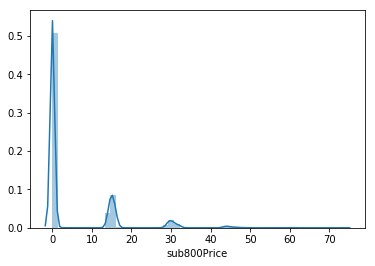

In [163]:
sns.distplot(train['sub800Price'])

### 지하철역 city

In [28]:
subway.columns

Index(['station_id', 'latitude', 'longitude', 'subway_line', 'address_by_law',
       'disTown', 'logPrice', 'noLine'],
      dtype='object')

In [31]:
subway['lines'] = subway['subway_line'].apply(lambda row : row.split(','))
subway['city'] = subway['lines'].apply(lambda row : 0 if row[0][0]=='B' else 1)

In [37]:
def cityDisTown(x):
    try:town=int(x['disTown'])
    except ValueError: return np.nan
    town = str(town)
    city = str(x['city'])
    return int(city+town)
subway['cityDisTown'] = subway.apply(lambda row : cityDisTown(row), axis=1)

### 지하철역 가치 구하기

In [56]:
townPrice = groupedTowns['logSupAreaPrice']['median']
def price(x):
    try : return townPrice[x]
    except KeyError : return np.nan
    except TypeError : return np.nan
subway['logPrice'] = subway['cityDisTown'].apply(lambda row : price(row))

### 지하철역 노선 갯수 구하기

In [62]:
subway['subway_line'].value_counts()

B1           36
5            36
B2           34
2            29
7            27
6            24
9            22
1            19
3            19
4            14
B4           12
BD           12
B3           11
KJ            8
8             7
BK            7
DL            6
2,5           4
1,7           3
3,6           3
3,DL          2
2,9           2
1,KJ,KC       2
B2,B3         2
2,7           2
1,4           2
4,7           2
ND            2
2,6           2
1,6           2
             ..
3,4           1
2,ND          1
6,KJ          1
2,DL          1
2,KJ,AP       1
B1,B2         1
2,4           1
4,US          1
3,8           1
B1,BD         1
5,7           1
KC            1
KC,KJ         1
5,6,KJ,AP     1
1,9           1
3,KJ          1
4,6           1
6,KJ,AP       1
3,ND          1
3,5           1
B2,BK         1
6,US          1
4,9           1
9,DL          1
2,4,5         1
B3,BK         1
1,3,5         1
B3,B4         1
KJ,KC         1
1,2,US        1
Name: subway_line, Lengt

In [63]:
subway['noLine'] = subway['subway_line'].apply(lambda row : len(row.split(',')))
subway['noLine'].head(10)

0    4
1    2
2    1
3    3
4    1
5    2
6    3
7    1
8    3
9    2
Name: noLine, dtype: int64

## School

In [31]:
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 9 columns):
school_code        1921 non-null object
latitude           1921 non-null float64
longitude          1921 non-null float64
school_class       1921 non-null object
operation_type     1921 non-null object
highschool_type    462 non-null object
gender             1921 non-null object
foundation_date    1921 non-null object
address_by_law     1921 non-null int64
dtypes: float64(2), int64(1), object(6)
memory usage: 135.1+ KB


### class

In [32]:
colInfo('school_class', school)

object
elementary    901
middle        558
high          462
Name: school_class, dtype: int64
train na :  0


In [33]:
def classCnvrt(x):
    if x =='elementary': return 0
    elif x =='middle' : return 1
    else : return 2
school['school_class'] = school['school_class'].apply(lambda row : classCnvrt(row))

### op type

In [17]:
colInfo('operation_type', school)

object
public      1444
private      466
national      11
Name: operation_type, dtype: int64
train na :  0


In [35]:
school['private'] = (school['operation_type']=='private')

In [37]:
def opCnvrt(x):
    if x == 'public' : return 0
    elif x=='private' : return 2
    else : return 1
school['operation_type'] = school['operation_type'].apply(lambda row : opCnvrt(row))

### high school

In [18]:
colInfo('highschool_type', school)

object
NaN            1459
general         269
specialized     104
autonomous       55
objective        34
Name: highschool_type, dtype: int64
train na :  1459


In [39]:
def highCnvrt(x):
    if x=='general' : return 0
    elif x=='specialized' : return 1
    elif x=='autonomous' : return 2
    elif x=='objective' : return 3
school['highschool_type'] = school['highschool_type'].apply(lambda row : highCnvrt(row))

### gender

In [40]:
colInfo('gender', school)

object
both      1524
male       199
female     198
Name: gender, dtype: int64
train na :  0


In [42]:
school['onlySex'] = (school['gender']!='both')
def genderCnvrt(x):
    if x=='both' : return 2
    elif x=='male' : return 1
    else : return 0
school['gender'] = school['gender'].apply(lambda row : genderCnvrt(row))

### date

In [43]:
colInfo('foundation_date', school)

object
2009.3.1      19
1984.1.9      16
1990.1.20     16
2002.3.1      15
1986.1.29     15
2004.3.1      14
1984.12.8     13
1972.12.29    13
2003.3.1      12
1984.12.17    12
1982.12.9     12
1994.1.5      10
2005.3.1      10
1983.12.3     10
1986.12.17    10
1945.11.1     10
1982.7.7       9
1968.8.6       9
1980.1.24      9
1991.1.21      9
2006.3.1       8
1984.3.1       8
1974.1.5       8
1991.10.30     8
1988.12.24     8
2012.3.1       7
2010.3.1       7
1983.12.26     7
2017.3.1       7
1996.3.1       7
              ..
1993.1.16      1
1894-09-18     1
1904.4.1       1
1978.12.19     1
1945.11.10     1
1906.4.1       1
1986.10.4      1
1955.2.28      1
1968.10.23     1
1944.4.11      1
1987.5.12      1
1978.12.29     1
1986.3.4       1
1967.3.15      1
1967.3.31      1
1982.11.3      1
2002.7.12      1
1960.5.15      1
1981.12.1      1
1979.2.2       1
1956.2.23      1
1938.2.24      1
1965.9.25      1
1946.7.2       1
1955.4.5       1
1959.4.1       1
1955.1.12      1
2012.9.

### School City, dist, town
- 위도로 서울/부산 구별

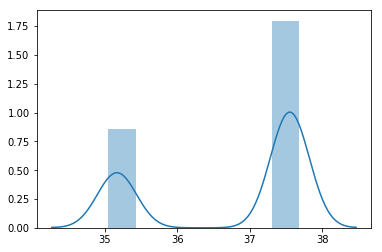

In [42]:
sns.distplot(school['latitude'].unique().tolist())

In [43]:
print(school['latitude'].min(),school['latitude'].max())

35.0508488 37.68669133


In [44]:
school['city'] = school['latitude'].apply(lambda row : 1 if row>36.5 else 0)

In [45]:
school['cityDisTown'] = school.apply(lambda row : int(str(row['city'])+str(row['address_by_law'])[2:8]), axis=1)

### school Value

In [57]:
def price(x):
    try : return townPrice[x]
    except KeyError : return np.nan
    except TypeError : return np.nan
school['logPrice'] = school['cityDisTown'].apply(lambda row : price(row))

### School Distance

In [113]:
schooLoc = school[['school_code', lat, lot]].groupby(['school_code']).agg('mean')
schoolIdx = schooLoc.index.tolist()
schooLoc = schooLoc.values
schooLoc= dict(zip(schoolIdx, schooLoc))

schDist = {a:{s:None for s in schoolIdx} for a in apartIdx} # row(0) : apart, col(1) : station
for s in tqdm(schoolIdx):
    for a in apartIdx:
        width = abs(schooLoc[s][0] - apartment[a][0])*110000
        height = abs(schooLoc[s][1] - apartment[a][1])*88740
        dist = math.sqrt(width**2+height**2)
        schDist[a][s] = dist


 78%|████████████████████████████████▌         | 1490/1921 [00:21<00:07, 58.68it/s]


100%|██████████████████████████████████████████| 1921/1921 [00:27<00:00, 68.89it/s]